Welcome to the exercise sheet about Recurrent Neural Networks. In this exercise sheet, we will take a closer look into RNNs, LSTMs and other variations.


The main task is to implement the same models as in the lecture and run the classification on the MNIST dataset.

## Imports


Let's first import all the dependencies we will need for this exercise.

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Loading the Dataset and making it iterable


In [8]:

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Exercise 1.1: Creating the model classes

Implement the RNN and the LSTM models from the lecture starting with one hidden layer and a tanh activation function for the RNN. Hint: The PyTorch packages provides built-in RNN and LSTM models.

In [3]:
# The RNN
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, add_fc, output_dim):
        super(RNNModel, self).__init__()
        # Parameters
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.add_fc = add_fc

        # Building your RNN
        self.rnn = nn.RNN(input_dim, self.hidden_dim, self.layer_dim, batch_first=True, nonlinearity='tanh')
       
        self.fc = nn.Linear(self.hidden_dim, self.hidden_dim)
        # Readout layer
        self.ro = nn.Linear(self.hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        
        #Define the forward steps
        out, hn = self.rnn(x, h0)

        if self.add_fc:
            out = self.fc(out[:, -1, :])
            out = torch.tanh(out)
            out = self.ro(out)
        else:
            out = self.ro(out[:, -1, :])

        return out
    
# The LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, add_fc, output_dim):
        super(LSTMModel, self).__init__()
        # Parameters
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.add_fc = add_fc
        
        # Building your LSTM
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.layer_dim, batch_first=True)

        self.fc = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        # Readout layer
        self.ro = nn.Linear(self.hidden_dim, self.output_dim)
    
    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # Define the forward steps
        out, (hn, cn) = self.lstm(x, (h0, h0))


        if self.add_fc:
            out = self.fc(out[:, -1, :])
            out = torch.tanh(out)
            out = self.ro(out)
        else:
            out = self.ro(out[:, -1, :])

        return out

### Exercise 1.2: Instantiations

In [4]:
#Instantiate the model classes

model_rnn  = RNNModel(input_dim=28, hidden_dim=100, layer_dim=1, output_dim=10, add_fc=False)
model_lstm = LSTMModel(input_dim=28, hidden_dim=100, layer_dim=1, output_dim=10, add_fc=False)


#Move to GPU if available
model_rnn.to(device)
model_lstm.to(device)
    
#Instantiate the Loss
criterion = nn.CrossEntropyLoss()

#Instantiate the Optimizer
learning_rate = 0.1
optimizer_rnn = torch.optim.SGD(model_rnn.parameters(), lr=learning_rate)
optimizer_lstm = torch.optim.SGD(model_lstm.parameters(), lr=learning_rate)

## Exercise 1.3: Training the models

Below, you find the training steps for the RNN model. Implement the training for the LSTM model accordingly.

In [11]:
# RNN Training
# Number of steps to unroll
seq_dim = 28
input_dim = 28

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        images = images.view(-1, seq_dim, input_dim).to(device)
        labels = labels.to(device)
            
        # Clear gradients w.r.t. parameters
        optimizer_rnn.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model_rnn(images)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer_rnn.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim).to(device))
                labels = labels.to(device)
                
                # Forward pass only to get logits/output
                outputs = model_rnn(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum().item()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.5621980428695679. Accuracy: 84.36
Iteration: 1000. Loss: 0.23162893950939178. Accuracy: 92.22
Iteration: 1500. Loss: 0.510516345500946. Accuracy: 90.57
Iteration: 2000. Loss: 0.21962757408618927. Accuracy: 91.96
Iteration: 2500. Loss: 0.37487924098968506. Accuracy: 87.28
Iteration: 3000. Loss: 1.1222999095916748. Accuracy: 82.45


In [12]:
# LSTM Training
# Number of steps to unroll
seq_dim = 28
input_dim = 28

iter = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        images = images.view(-1, seq_dim, input_dim).to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer_lstm.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model_lstm(images)
        
        # Calculate Loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer_lstm.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0       
            
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim).to(device))
                labels = labels.to(device)
            
                # Forward pass only to get logits/output
                outputs = model_lstm(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
                
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.242713689804077. Accuracy: 17.4
Iteration: 1000. Loss: 1.2380925416946411. Accuracy: 61.06
Iteration: 1500. Loss: 0.45741915702819824. Accuracy: 83.3
Iteration: 2000. Loss: 0.2595846652984619. Accuracy: 92.3
Iteration: 2500. Loss: 0.22072629630565643. Accuracy: 94.34
Iteration: 3000. Loss: 0.13182492554187775. Accuracy: 95.34


## Exercise 2: Classification
We want to compare different model configurations with each other. 

For the RNN: 
* 1, 2, 3 or 4 hidden layers
* tanh and ReLu activation function 
* Additional fully connected layer

For the LSTM: 
* 1, 2 or 3 hidden layers
* Additional fully connected layer


### Exercise 2.1:
Change the above implementation to allow for an efficient way to compare the final classification accuracies in one cell (i.e. define training methods and add model parameters). 


In [9]:
import pandas as pd
# RNN Training
# Number of steps to unroll
seq_dim = 28
input_dim = 28
output_dim = 10
learning_rate = 0.1

def train_model(model, criterion, optimizer, train_loader):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, seq_dim, input_dim).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    return running_loss / len(train_loader)

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, seq_dim, input_dim).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

layer_dim = [1, 2, 3, 4]
activation = ['tanh', 'relu']
add_fc = [False, True]

results = pd.DataFrame(columns=['RNN_Layers', 'Activation', 'Add_FC','Epoch', 'Train Loss', 'Test Accuracy'])

for layer in layer_dim:
    for act in activation:
        for fc in add_fc:
            model_rnn = RNNModel(input_dim, 100, layer, fc, output_dim)
            model_rnn.to(device)
            optimizer_rnn = torch.optim.SGD(model_rnn.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()

            for epoch in range(num_epochs):
                train_loss = train_model(model_rnn, criterion, optimizer_rnn, train_loader)
                test_acc = test_model(model_rnn, test_loader)
                results = results._append({'RNN_Layers': layer, 'Activation': act,'Add_FC': fc,'Epoch': epoch,'Train Loss': train_loss,'Test Accuracy': test_acc}, ignore_index=True)
                print(results.iloc[-1])


results.to_csv('results.csv', index=False)



/tmp/ipykernel_2784/3389781470.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append({'RNN_Layers': layer, 'Activation': act,'Add_FC': fc,'Epoch': epoch,'Train Loss': train_loss,'Test Accuracy': test_acc}, ignore_index=True)


RNN_Layers              1
Activation           tanh
Add_FC              False
Epoch                   0
Train Loss       1.430596
Test Accuracy       73.06
Name: 0, dtype: object
RNN_Layers              1
Activation           tanh
Add_FC              False
Epoch                   1
Train Loss       0.633105
Test Accuracy       89.07
Name: 1, dtype: object
RNN_Layers              1
Activation           tanh
Add_FC              False
Epoch                   2
Train Loss       0.444878
Test Accuracy        90.5
Name: 2, dtype: object
RNN_Layers              1
Activation           tanh
Add_FC              False
Epoch                   3
Train Loss       0.323728
Test Accuracy       93.39
Name: 3, dtype: object
RNN_Layers              1
Activation           tanh
Add_FC              False
Epoch                   4
Train Loss       0.302182
Test Accuracy       93.54
Name: 4, dtype: object
RNN_Layers              1
Activation           tanh
Add_FC               True
Epoch                   0
T

    RNN_Layers Activation  Add_FC  Epoch  Train Loss  Test Accuracy
0            1       tanh   False      0    1.430596          73.06
1            1       tanh   False      1    0.633105          89.07
2            1       tanh   False      2    0.444878          90.50
3            1       tanh   False      3    0.323728          93.39
4            1       tanh   False      4    0.302182          93.54
20           2       tanh   False      0    1.140248          75.10
21           2       tanh   False      1    0.451419          91.67
22           2       tanh   False      2    0.292581          91.76
23           2       tanh   False      3    0.221865          95.20
24           2       tanh   False      4    0.194953          93.51
40           3       tanh   False      0    1.069791          85.84
41           3       tanh   False      1    0.394195          93.46
42           3       tanh   False      2    0.250130          95.11
43           3       tanh   False      3    0.18

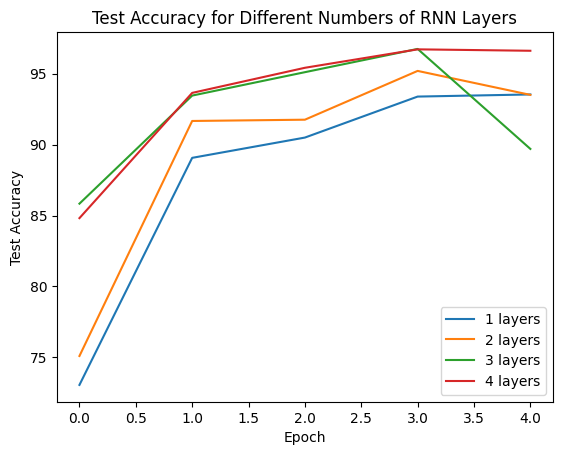

In [10]:
# read dataframe from csv
import pandas as pd
results = pd.read_csv('C:/Users/m-gre/Documents/Advanced Machine Learning/uni-bremen-aml-course/Mario/Exercise_3/results.csv')


import matplotlib.pyplot as plt

# Filter the DataFrame
filtered_df = results[(results['Activation'] == 'tanh') & (results['Add_FC'] == False)]
print(filtered_df)
print(results)

# Plot the results
for layer in filtered_df['RNN_Layers'].unique():
    layer_df = filtered_df[filtered_df['RNN_Layers'] == layer]
    plt.plot(layer_df['Epoch'], layer_df['Test Accuracy'], label=f'{layer} layers')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for Different Numbers of RNN Layers')
plt.legend()
plt.show()

### Exercise 2.2:
Do your results differ from the results presented in the lecture? If so, why?

In [ ]:
## Your answer goes here

## Exercise 3:

So far, we always trained for 3000 iterations with a batch size of 100 and a learning rate of 0.1. Our classification accuracies might be improved, if we change these values. Systematically change these values and find a better combination (if possible). 

In [ ]:
## your code goes here

## Exercise 4: 
1. Why might the LSTM result in better classification accuracies? What are the advantages and disadvantages of using an LSTM in this task, compared to an RNN?
2. We addressed other variants of RNNs in the lecture. Which of them might be suitable for this classification task an why? (GRU, bidirectional RNN, Recursive Neural Network, Encoder-Decoder RNN)